
# Fraud Detection EDA

Детальный разведочный анализ транзакций из `train.csv` для поиска закономерностей и идей для feature engineering.



**Цели анализа**

- понять структуру и качество данных
- изучить распределение таргета и ключевых признаков
- обнаружить аномалии и сезонность
- сформировать гипотезы для дальнейшего feature engineering


In [ ]:

from pathlib import Path
import numpy as np
import seaborn as sns
import io
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from IPython.display import display, Markdown

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)
project_root = Path.cwd().resolve()
candidates = [
    project_root / "train.csv",
    project_root / "data" / "train.csv",
    project_root / "source" / "data" / "train.csv",
    project_root.parent / "data" / "train.csv",
    project_root.parent / "source" / "data" / "train.csv",
]
for candidate in candidates:
    if candidate.exists():
        DATA_PATH = candidate
        break
else:
    raise FileNotFoundError("Не удалось найти train.csv относительно ноутбука.")

print(f"Используем файл: {DATA_PATH}")
df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
df["transaction_time"] = pd.to_datetime(df["transaction_time"], errors="coerce")
print(f"Размерность набора: {df.shape[0]:,} строк x {df.shape[1]} колонок")
df.head()


Используем файл: /Users/slava/Documents/study/hse/mlops/hw1/source/data/train.csv
Размерность набора: 786,431 строк x 18 колонок


,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon,target
0,2019-12-27 15:21:00,fraud_Cormier LLC,health_fitness,148.04,Daniel,Martinez,M,8510 Acevedo Burgs,Kent,OR,97033,45.08,-120.66,60,Museum education officer,45.04,-120.71,0
1,2019-04-17 23:09:00,"fraud_Brown, Homenick and Lesch",health_fitness,39.40,Grace,Williams,F,28812 Charles Mill Apt. 628,Plantersville,AL,36758,32.62,-86.95,1412,Drilling engineer,31.87,-87.83,0
2,2019-09-23 15:02:00,fraud_Ruecker-Mayert,kids_pets,52.96,Kyle,Park,M,7507 Larry Passage Suite 859,Mount Perry,OH,43760,39.88,-82.19,1831,Barrister's clerk,40.01,-81.84,0
3,2019-05-13 16:00:00,"fraud_Mante, Luettgen and Hackett",health_fitness,7.66,Monique,Martin,F,68276 Matthew Springs,Ratcliff,TX,75858,31.38,-95.06,43,"Engineer, production",30.89,-95.14,0
4,2019-08-18 07:27:00,fraud_Luettgen PLC,gas_transport,51.59,Christine,Johnson,F,8011 Chapman Tunnel Apt. 568,Blairsden-Graeagle,CA,96103,39.81,-120.64,1725,Chartered legal executive (England and Wales),39.38,-121.31,0


In [3]:

buffer = io.StringIO()
df.info(buf=buffer, memory_usage="deep")
print(buffer.getvalue())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786431 entries, 0 to 786430
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_time  786431 non-null  datetime64[ns]
 1   merch             786431 non-null  object        
 2   cat_id            786431 non-null  object        
 3   amount            786431 non-null  float64       
 4   name_1            786431 non-null  object        
 5   name_2            786431 non-null  object        
 6   gender            786431 non-null  object        
 7   street            786431 non-null  object        
 8   one_city          786431 non-null  object        
 9   us_state          786431 non-null  object        
 10  post_code         786431 non-null  int64         
 11  lat               786431 non-null  float64       
 12  lon               786431 non-null  float64       
 13  population_city   786431 non-null  int64         
 14  jobs

In [4]:

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number, "datetime"]).columns.tolist()
print(f"Числовых признаков: {len(numeric_cols)} | Категориальных признаков: {len(categorical_cols)}")
display(df[numeric_cols].describe().T)
if categorical_cols:
    display(df[categorical_cols].describe().T)


Числовых признаков: 8 | Категориальных признаков: 9


,count,mean,std,min,25%,50%,75%,max
amount,"786,431.00",70.24,161.09,1.00,9.65,47.41,83.00,"27,390.12"
post_code,"786,431.00","48,802.52","26,896.56","1,257.00","26,237.00","48,174.00","72,042.00","99,783.00"
lat,"786,431.00",38.53,5.08,20.03,34.62,39.35,41.89,66.69
lon,"786,431.00",-90.22,13.75,-165.67,-96.80,-87.48,-80.16,-67.95
population_city,"786,431.00","89,288.53","302,860.01",23.00,743.00,"2,456.00","20,478.00","2,906,700.00"
merchant_lat,"786,431.00",38.53,5.11,19.03,34.73,39.36,41.95,67.44
merchant_lon,"786,431.00",-90.22,13.77,-166.67,-96.90,-87.44,-80.23,-66.96
target,"786,431.00",0.01,0.08,0.00,0.00,0.00,0.00,1.00


,count,unique,top,freq
merch,786431,693,fraud_Kilback LLC,2659
cat_id,786431,14,gas_transport,79995
name_1,786431,348,Christopher,16075
name_2,786431,479,Smith,17565
gender,786431,2,F,430496
street,786431,965,4664 Sanchez Common Suite 930,1914
one_city,786431,879,Birmingham,3406
us_state,786431,51,TX,57639
jobs,786431,493,Film/video editor,5867


In [5]:

missing = (
    df.isna()
    .sum()
    .to_frame(name="missing_count")
    .assign(missing_pct=lambda s: s["missing_count"] / len(df) * 100)
    .sort_values("missing_pct", ascending=False)
)
display(missing)


,missing_count,missing_pct
transaction_time,0,0.00
merch,0,0.00
merchant_lon,0,0.00
merchant_lat,0,0.00
jobs,0,0.00
population_city,0,0.00
lon,0,0.00
lat,0,0.00
post_code,0,0.00
us_state,0,0.00


In [6]:

duplicate_rows = df.duplicated().sum()
print(f"Дублирующих транзакций: {duplicate_rows:,} ({duplicate_rows / len(df) * 100:.4f}% от выборки)")


Дублирующих транзакций: 0 (0.0000% от выборки)



## Таргет и баланс классов


In [7]:

target_counts = (
    df["target"].value_counts()
    .rename_axis("target")
    .to_frame("transactions")
    .assign(share_pct=lambda s: s["transactions"] / len(df) * 100)
    .sort_index()
)
target_counts["label"] = target_counts.index.map({0: "Legit", 1: "Fraud"})
target_counts["fraud_rate_pct"] = df["target"].mean() * 100
display(target_counts)
print(f"Общий уровень фрода: {df['target'].mean() * 100:.3f}%")


,transactions,share_pct,label,fraud_rate_pct
target,,,,
0,781927,99.43,Legit,0.57
1,4504,0.57,Fraud,0.57


Общий уровень фрода: 0.573%


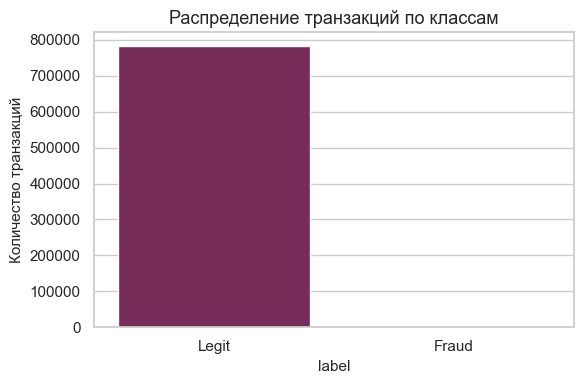

In [8]:

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(
    data=target_counts.reset_index(),
    x="label",
    y="transactions",
    palette="rocket",
    ax=ax,
)
ax.set_title("Распределение транзакций по классам")
ax.set_ylabel("Количество транзакций")
plt.tight_layout()
plt.show()



## Анализ сумм транзакций


In [9]:

amount_stats = (
    df.groupby("target")["amount"]
    .agg(count="count", mean="mean", median="median", std="std", min="min", max="max")
    .rename(index={0: "Legit", 1: "Fraud"})
)
display(amount_stats)


,count,mean,median,std,min,max
target,,,,,,
Legit,781927,67.59,47.18,154.91,1.00,"27,390.12"
Fraud,4504,529.89,396.50,390.33,1.18,"1,334.07"


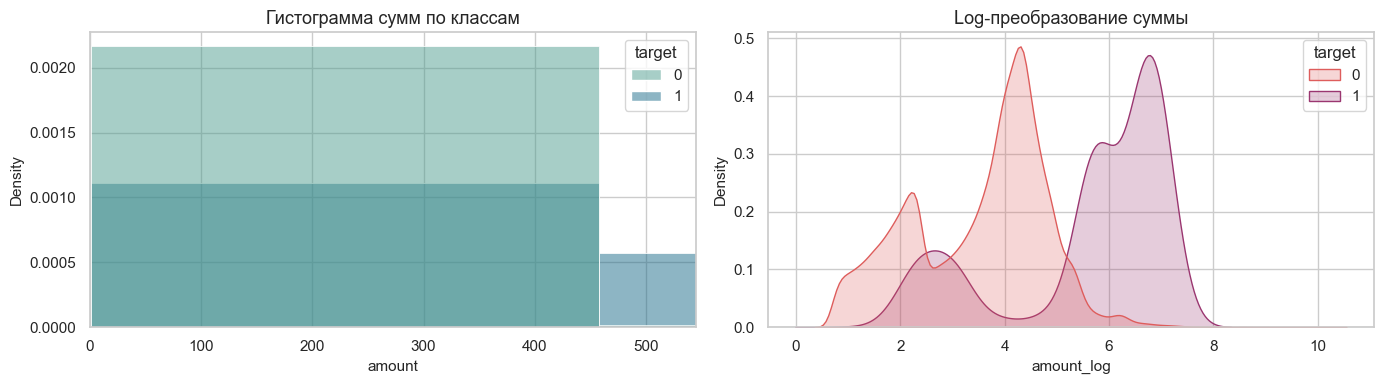

In [10]:

sample_size = min(200_000, len(df))
sample = df.sample(n=sample_size, random_state=RANDOM_STATE)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(
    data=sample,
    x="amount",
    hue="target",
    bins=60,
    stat="density",
    common_norm=False,
    palette="crest",
    ax=axes[0],
    alpha=0.5,
)
axes[0].set_title("Гистограмма сумм по классам")
axes[0].set_xlim(0, np.percentile(sample["amount"], 99))

sample = sample.assign(amount_log=np.log1p(sample["amount"]))
sns.kdeplot(
    data=sample,
    x="amount_log",
    hue="target",
    fill=True,
    common_norm=False,
    palette="flare",
    ax=axes[1],
)
axes[1].set_title("Log-преобразование суммы")
plt.tight_layout()
plt.show()


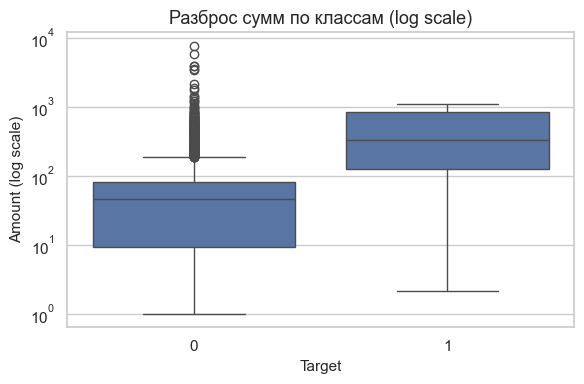

In [11]:

box_sample = df.sample(n=min(10000, len(df)), random_state=RANDOM_STATE)
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=box_sample, x="target", y="amount", ax=ax)
ax.set_yscale("log")
ax.set_xlabel("Target")
ax.set_ylabel("Amount (log scale)")
ax.set_title("Разброс сумм по классам (log scale)")
plt.tight_layout()
plt.show()



## Инженерные признаки для времени и географии


In [12]:

df_enriched = df.copy()
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_enriched["transaction_date"] = df_enriched["transaction_time"].dt.date
df_enriched["transaction_hour"] = df_enriched["transaction_time"].dt.hour
df_enriched["transaction_dayofweek"] = pd.Categorical(
    df_enriched["transaction_time"].dt.day_name(), categories=weekday_order, ordered=True
)
df_enriched["transaction_month"] = df_enriched["transaction_time"].dt.to_period("M").astype(str)
df_enriched["is_weekend"] = df_enriched["transaction_dayofweek"].isin(["Saturday", "Sunday"])
df_enriched["amount_log"] = np.log1p(df_enriched["amount"])
df_enriched["population_log"] = np.log1p(df_enriched["population_city"])

EARTH_RADIUS_KM = 6371

lat1 = np.radians(df_enriched["lat"].to_numpy())
lon1 = np.radians(df_enriched["lon"].to_numpy())
lat2 = np.radians(df_enriched["merchant_lat"].to_numpy())
lon2 = np.radians(df_enriched["merchant_lon"].to_numpy())
dlat = lat2 - lat1
dlon = lon2 - lon1
a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
df_enriched["customer_merchant_distance_km"] = EARTH_RADIUS_KM * c

df_enriched["same_location_5km"] = df_enriched["customer_merchant_distance_km"] <= 5
df_enriched["lat_diff_abs"] = (df_enriched["lat"] - df_enriched["merchant_lat"]).abs()
df_enriched["lon_diff_abs"] = (df_enriched["lon"] - df_enriched["merchant_lon"]).abs()
df_enriched["population_city_bin"] = pd.qcut(
    df_enriched["population_city"], q=5, duplicates="drop"
)

display(df_enriched.head())


,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon,target,transaction_date,transaction_hour,transaction_dayofweek,transaction_month,is_weekend,amount_log,population_log,customer_merchant_distance_km,same_location_5km,lat_diff_abs,lon_diff_abs,population_city_bin
0,2019-12-27 15:21:00,fraud_Cormier LLC,health_fitness,148.04,Daniel,Martinez,M,8510 Acevedo Burgs,Kent,OR,97033,45.08,-120.66,60,Museum education officer,45.04,-120.71,0,2019-12-27,15,Friday,2019-12,False,5.00,4.11,5.74,False,0.04,0.04,"(22.999, 568.0]"
1,2019-04-17 23:09:00,"fraud_Brown, Homenick and Lesch",health_fitness,39.40,Grace,Williams,F,28812 Charles Mill Apt. 628,Plantersville,AL,36758,32.62,-86.95,1412,Drilling engineer,31.87,-87.83,0,2019-04-17,23,Wednesday,2019-04,False,3.70,7.25,117.17,False,0.75,0.88,"(568.0, 1631.0]"
2,2019-09-23 15:02:00,fraud_Ruecker-Mayert,kids_pets,52.96,Kyle,Park,M,7507 Larry Passage Suite 859,Mount Perry,OH,43760,39.88,-82.19,1831,Barrister's clerk,40.01,-81.84,0,2019-09-23,15,Monday,2019-09,False,3.99,7.51,33.01,False,0.13,0.35,"(1631.0, 4726.0]"
3,2019-05-13 16:00:00,"fraud_Mante, Luettgen and Hackett",health_fitness,7.66,Monique,Martin,F,68276 Matthew Springs,Ratcliff,TX,75858,31.38,-95.06,43,"Engineer, production",30.89,-95.14,0,2019-05-13,16,Monday,2019-05,False,2.16,3.78,55.55,False,0.49,0.08,"(22.999, 568.0]"
4,2019-08-18 07:27:00,fraud_Luettgen PLC,gas_transport,51.59,Christine,Johnson,F,8011 Chapman Tunnel Apt. 568,Blairsden-Graeagle,CA,96103,39.81,-120.64,1725,Chartered legal executive (England and Wales),39.38,-121.31,0,2019-08-18,7,Sunday,2019-08,True,3.96,7.45,75.27,False,0.44,0.67,"(1631.0, 4726.0]"



## Временные паттерны


,transaction_hour,transactions,frauds,fraud_rate,avg_amount,fraud_rate_pct,share_pct
0,0,25759,407,0.02,78.82,1.58,3.28
1,1,26120,416,0.02,79.51,1.59,3.32
2,2,25667,385,0.01,80.78,1.50,3.26
3,3,26026,364,0.01,79.06,1.40,3.31
4,4,25397,32,0.00,75.43,0.13,3.23


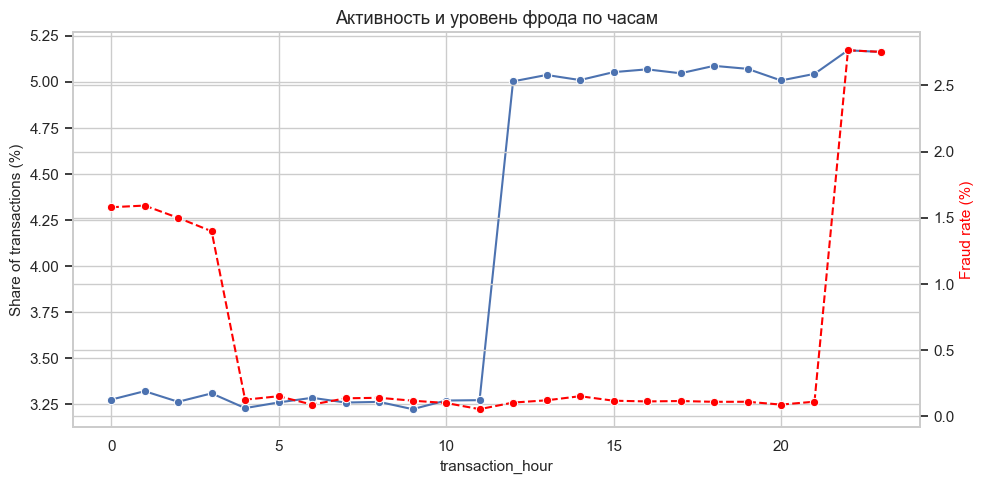

In [13]:

hour_stats = (
    df_enriched.groupby("transaction_hour")
    .agg(
        transactions=("target", "size"),
        frauds=("target", "sum"),
        fraud_rate=("target", "mean"),
        avg_amount=("amount", "mean"),
    )
    .reset_index()
)
hour_stats["fraud_rate_pct"] = hour_stats["fraud_rate"] * 100
hour_stats["share_pct"] = hour_stats["transactions"] / len(df_enriched) * 100
display(hour_stats.head())

fig, ax1 = plt.subplots(figsize=(10, 5))
sns.lineplot(data=hour_stats, x="transaction_hour", y="share_pct", marker="o", ax=ax1)
ax1.set_ylabel("Share of transactions (%)")
ax1.set_title("Активность и уровень фрода по часам")

ax2 = ax1.twinx()
sns.lineplot(
    data=hour_stats,
    x="transaction_hour",
    y="fraud_rate_pct",
    color="red",
    linestyle="--",
    marker="o",
    ax=ax2,
)
ax2.set_ylabel("Fraud rate (%)", color="red")
plt.tight_layout()
plt.show()


,transaction_dayofweek,transactions,frauds,fraud_rate,fraud_rate_pct
0,Monday,154474,715,0.00,0.46
1,Tuesday,84565,515,0.01,0.61
2,Wednesday,80509,506,0.01,0.63
3,Thursday,90293,578,0.01,0.64
4,Friday,91594,640,0.01,0.70
5,Saturday,128340,800,0.01,0.62
6,Sunday,156656,750,0.00,0.48


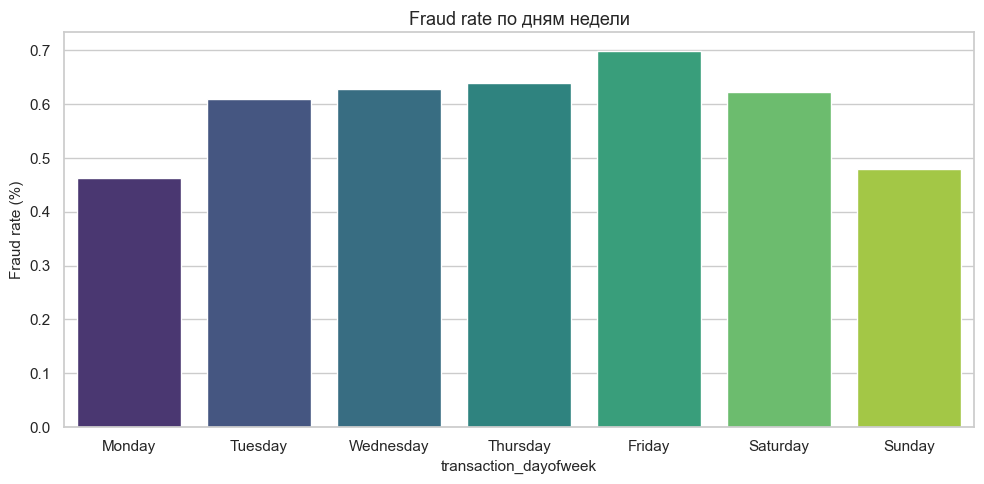

In [14]:

dow_stats = (
    df_enriched.groupby("transaction_dayofweek")
    .agg(
        transactions=("target", "size"),
        frauds=("target", "sum"),
        fraud_rate=("target", "mean"),
    )
    .reset_index()
)
dow_stats["fraud_rate_pct"] = dow_stats["fraud_rate"] * 100

display(dow_stats)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=dow_stats, x="transaction_dayofweek", y="fraud_rate_pct", palette="viridis", ax=ax)
ax.set_title("Fraud rate по дням недели")
ax.set_ylabel("Fraud rate (%)")
plt.tight_layout()
plt.show()


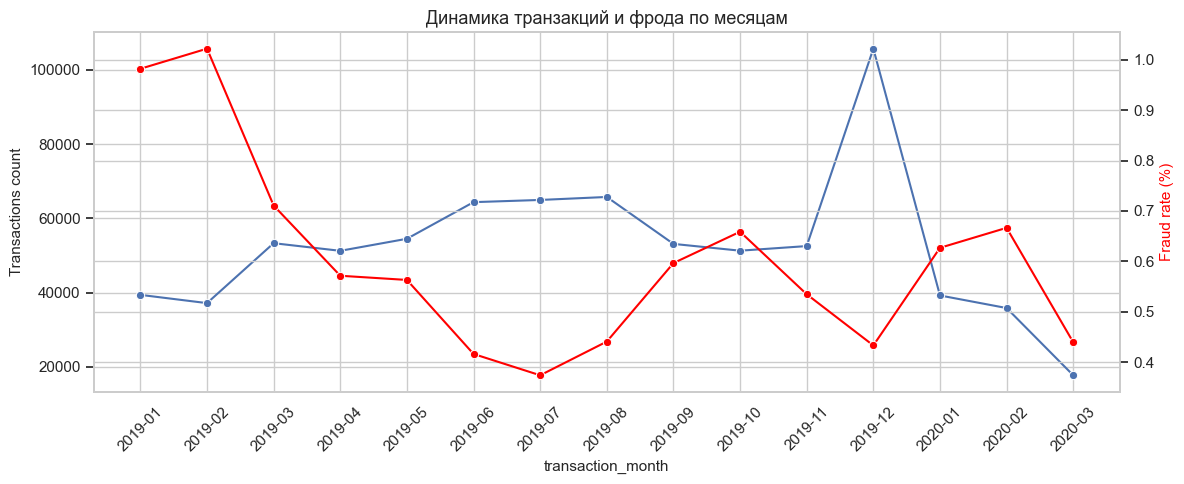

In [15]:

monthly_stats = (
    df_enriched.groupby("transaction_month")
    .agg(
        transactions=("target", "size"),
        frauds=("target", "sum"),
        fraud_rate=("target", "mean"),
    )
    .reset_index()
)
monthly_stats["fraud_rate_pct"] = monthly_stats["fraud_rate"] * 100

fig, ax1 = plt.subplots(figsize=(12, 5))
sns.lineplot(data=monthly_stats, x="transaction_month", y="transactions", marker="o", ax=ax1)
ax1.set_xticklabels(monthly_stats["transaction_month"], rotation=45)
ax1.set_ylabel("Transactions count")
ax1.set_title("Динамика транзакций и фрода по месяцам")

ax2 = ax1.twinx()
sns.lineplot(data=monthly_stats, x="transaction_month", y="fraud_rate_pct", color="red", marker="o", ax=ax2)
ax2.set_ylabel("Fraud rate (%)", color="red")
plt.tight_layout()
plt.show()



## Обобщающие функции для категориальных признаков


In [16]:

def summarize_categorical(data: pd.DataFrame, feature: str, min_count: int = 200) -> pd.DataFrame:
    """Compute transactions, fraud volume and rate with basic filtering."""
    summary = (
        data.groupby(feature)["target"]
        .agg(
            transactions="count",
            frauds="sum",
            fraud_rate="mean",
        )
        .sort_values("fraud_rate", ascending=False)
    )
    summary = summary[summary["transactions"] >= min_count]
    summary["share_pct"] = summary["transactions"] / len(data) * 100
    summary["fraud_rate_pct"] = summary["fraud_rate"] * 100
    return summary

cat_summary = summarize_categorical(df_enriched, "cat_id", min_count=500)
cat_summary


,transactions,frauds,fraud_rate,share_pct,fraud_rate_pct
cat_id,,,,,
shopping_net,59080,1019,0.02,7.51,1.72
misc_net,38217,552,0.01,4.86,1.44
grocery_pos,74875,1049,0.01,9.52,1.40
shopping_pos,70861,509,0.01,9.01,0.72
gas_transport,79995,376,0.00,10.17,0.47
travel,24688,76,0.00,3.14,0.31
grocery_net,27435,80,0.00,3.49,0.29
misc_pos,48364,141,0.00,6.15,0.29
entertainment,56955,142,0.00,7.24,0.25


,transactions,frauds,fraud_rate,share_pct,fraud_rate_pct
cat_id,,,,,
gas_transport,79995,376,0.00,10.17,0.47
grocery_pos,74875,1049,0.01,9.52,1.40
home,74743,106,0.00,9.50,0.14
shopping_pos,70861,509,0.01,9.01,0.72
kids_pets,68421,142,0.00,8.70,0.21
shopping_net,59080,1019,0.02,7.51,1.72
entertainment,56955,142,0.00,7.24,0.25
food_dining,55636,93,0.00,7.07,0.17
personal_care,55136,134,0.00,7.01,0.24


,transactions,frauds,fraud_rate,share_pct,fraud_rate_pct
cat_id,,,,,
shopping_net,59080,1019,0.02,7.51,1.72
misc_net,38217,552,0.01,4.86,1.44
grocery_pos,74875,1049,0.01,9.52,1.40
shopping_pos,70861,509,0.01,9.01,0.72
gas_transport,79995,376,0.00,10.17,0.47
travel,24688,76,0.00,3.14,0.31
grocery_net,27435,80,0.00,3.49,0.29
misc_pos,48364,141,0.00,6.15,0.29
entertainment,56955,142,0.00,7.24,0.25


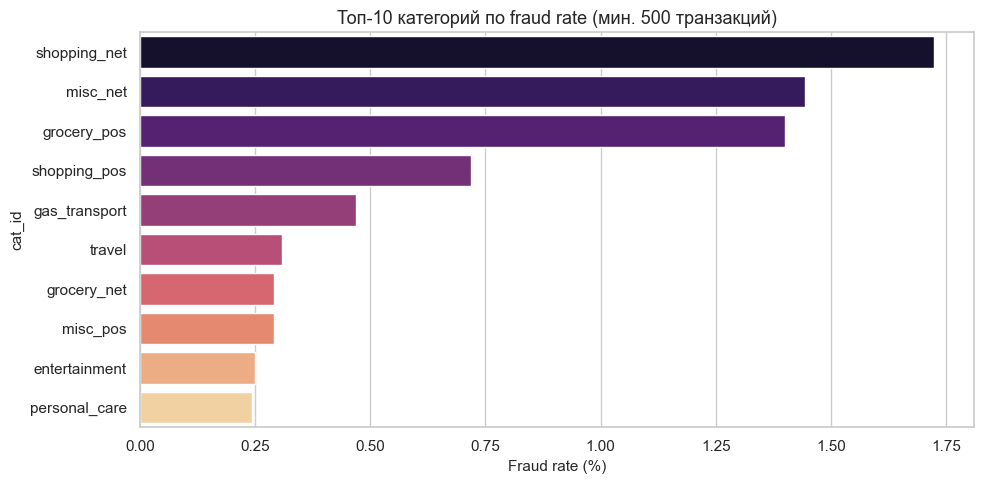

In [17]:

display(cat_summary.sort_values("transactions", ascending=False).head(10))
display(cat_summary.sort_values("fraud_rate", ascending=False).head(10))

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    data=cat_summary.sort_values("fraud_rate", ascending=False).head(10).reset_index(),
    x="fraud_rate_pct",
    y="cat_id",
    palette="magma",
    ax=ax,
)
ax.set_title("Топ-10 категорий по fraud rate (мин. 500 транзакций)")
ax.set_xlabel("Fraud rate (%)")
plt.tight_layout()
plt.show()



### Анализ мерчантов


In [18]:

merch_summary = summarize_categorical(df_enriched, "merch", min_count=300)
display(merch_summary.sort_values("fraud_rate", ascending=False).head(10))
display(merch_summary.sort_values("transactions", ascending=False).head(10))


,transactions,frauds,fraud_rate,share_pct,fraud_rate_pct
merch,,,,,
"fraud_Herman, Treutel and Dickens",746,20,0.03,0.09,2.68
fraud_Fisher-Schowalter,1183,29,0.02,0.15,2.45
"fraud_Gottlieb, Considine and Schultz",1187,28,0.02,0.15,2.36
fraud_Padberg-Welch,1481,34,0.02,0.19,2.30
fraud_Gleason-Macejkovic,1252,27,0.02,0.16,2.16
fraud_Kuhic LLC,1211,26,0.02,0.15,2.15
fraud_Gerlach Inc,1166,25,0.02,0.15,2.14
fraud_Rau and Sons,1493,32,0.02,0.19,2.14
"fraud_Towne, Greenholt and Koepp",1171,25,0.02,0.15,2.13


,transactions,frauds,fraud_rate,share_pct,fraud_rate_pct
merch,,,,,
fraud_Kilback LLC,2659,30,0.01,0.34,1.13
fraud_Cormier LLC,2256,26,0.01,0.29,1.15
fraud_Schumm PLC,2209,19,0.01,0.28,0.86
fraud_Boyer PLC,2130,26,0.01,0.27,1.22
fraud_Kuhn LLC,2113,25,0.01,0.27,1.18
fraud_Dickinson Ltd,2047,5,0.00,0.26,0.24
fraud_Bartoletti-Wunsch,1690,11,0.01,0.21,0.65
"fraud_Stroman, Hudson and Erdman",1679,7,0.00,0.21,0.42
fraud_Schmitt Inc,1671,9,0.01,0.21,0.54



### География и демография


In [19]:

state_summary = summarize_categorical(df_enriched, "us_state", min_count=1000)
display(state_summary.sort_values("fraud_rate", ascending=False).head(10))
display(state_summary.sort_values("transactions", ascending=False).head(10))


,transactions,frauds,fraud_rate,share_pct,fraud_rate_pct
us_state,,,,,
AK,1267,19,0.01,0.16,1.50
NE,14802,120,0.01,1.88,0.81
TN,10657,86,0.01,1.36,0.81
NV,3398,27,0.01,0.43,0.79
FL,26045,199,0.01,3.31,0.76
CO,8350,63,0.01,1.06,0.75
OR,11287,85,0.01,1.44,0.75
ME,10091,75,0.01,1.28,0.74
NH,4980,37,0.01,0.63,0.74


,transactions,frauds,fraud_rate,share_pct,fraud_rate_pct
us_state,,,,,
TX,57639,296,0.01,7.33,0.51
NY,50283,356,0.01,6.39,0.71
PA,48423,257,0.01,6.16,0.53
CA,34190,203,0.01,4.35,0.59
OH,28038,201,0.01,3.57,0.72
MI,27856,153,0.01,3.54,0.55
IL,26154,165,0.01,3.33,0.63
FL,26045,199,0.01,3.31,0.76
AL,24936,138,0.01,3.17,0.55


In [20]:

gender_summary = (
    df_enriched.groupby("gender")["target"]
    .agg(transactions="count", frauds="sum", fraud_rate="mean")
    .sort_values("fraud_rate", ascending=False)
)
gender_summary["fraud_rate_pct"] = gender_summary["fraud_rate"] * 100
display(gender_summary)


,transactions,frauds,fraud_rate,fraud_rate_pct
gender,,,,
M,355935,2244,0.01,0.63
F,430496,2260,0.01,0.52


In [21]:

job_summary = summarize_categorical(df_enriched, "jobs", min_count=200)
display(job_summary.sort_values("fraud_rate", ascending=False).head(10))
display(job_summary.sort_values("transactions", ascending=False).head(10))


,transactions,frauds,fraud_rate,share_pct,fraud_rate_pct
jobs,,,,,
Lawyer,331,21,0.06,0.04,6.34
Community development worker,339,18,0.05,0.04,5.31
TEFL teacher,325,17,0.05,0.04,5.23
Magazine journalist,318,12,0.04,0.04,3.77
"Geneticist, molecular",330,12,0.04,0.04,3.64
Clinical cytogeneticist,311,11,0.04,0.04,3.54
Air cabin crew,309,10,0.03,0.04,3.24
Charity officer,324,10,0.03,0.04,3.09
Civil Service administrator,292,9,0.03,0.04,3.08


,transactions,frauds,fraud_rate,share_pct,fraud_rate_pct
jobs,,,,,
Film/video editor,5867,25,0.00,0.75,0.43
Exhibition designer,5568,39,0.01,0.71,0.70
"Surveyor, land/geomatics",5294,40,0.01,0.67,0.76
Naval architect,5252,23,0.00,0.67,0.44
"Designer, ceramics/pottery",5059,7,0.00,0.64,0.14
Materials engineer,5016,38,0.01,0.64,0.76
IT trainer,4658,24,0.01,0.59,0.52
Systems developer,4653,9,0.00,0.59,0.19
Financial adviser,4588,11,0.00,0.58,0.24


In [22]:

population_summary = (
    df_enriched.groupby("population_city_bin")["target"]
    .agg(transactions="count", frauds="sum", fraud_rate="mean")
    .reset_index()
)
population_summary["fraud_rate_pct"] = population_summary["fraud_rate"] * 100
display(population_summary)


,population_city_bin,transactions,frauds,fraud_rate,fraud_rate_pct
0,"(22.999, 568.0]",157969,936,0.01,0.59
1,"(568.0, 1631.0]",156893,797,0.01,0.51
2,"(1631.0, 4726.0]",157805,909,0.01,0.58
3,"(4726.0, 42619.0]",156653,919,0.01,0.59
4,"(42619.0, 2906700.0]",157111,943,0.01,0.60


,count,mean,median,std,min,max
target,,,,,,
Legit,781927,76.08,78.19,29.11,0.02,152.12
Fraud,4504,76.21,78.06,28.79,1.45,144.52


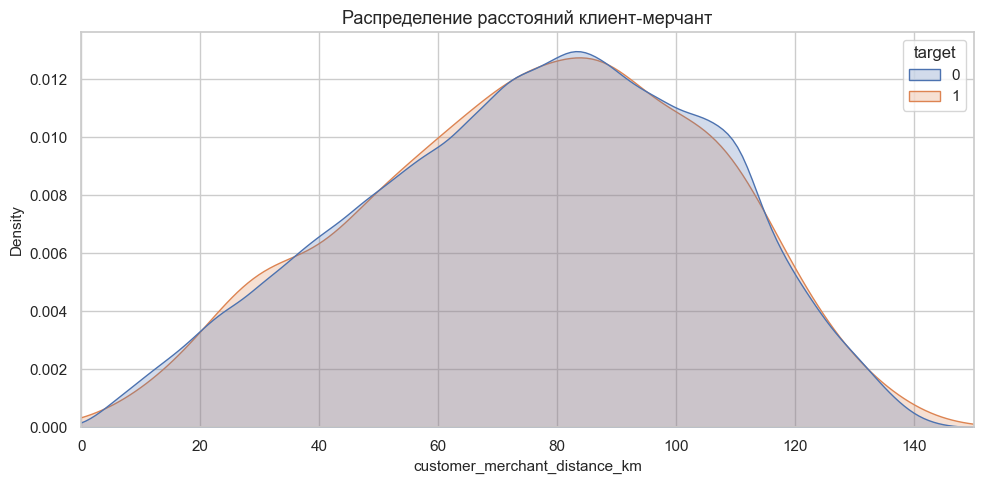

In [23]:

distance_summary = (
    df_enriched.groupby("target")["customer_merchant_distance_km"]
    .agg(count="count", mean="mean", median="median", std="std", min="min", max="max")
    .rename(index={0: "Legit", 1: "Fraud"})
)
display(distance_summary)

fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(
    data=df_enriched.sample(n=min(200000, len(df_enriched)), random_state=RANDOM_STATE),
    x="customer_merchant_distance_km",
    hue="target",
    fill=True,
    common_norm=False,
    ax=ax,
)
ax.set_xlim(0, 150)
ax.set_title("Распределение расстояний клиент-мерчант")
plt.tight_layout()
plt.show()



## Корреляции числовых признаков


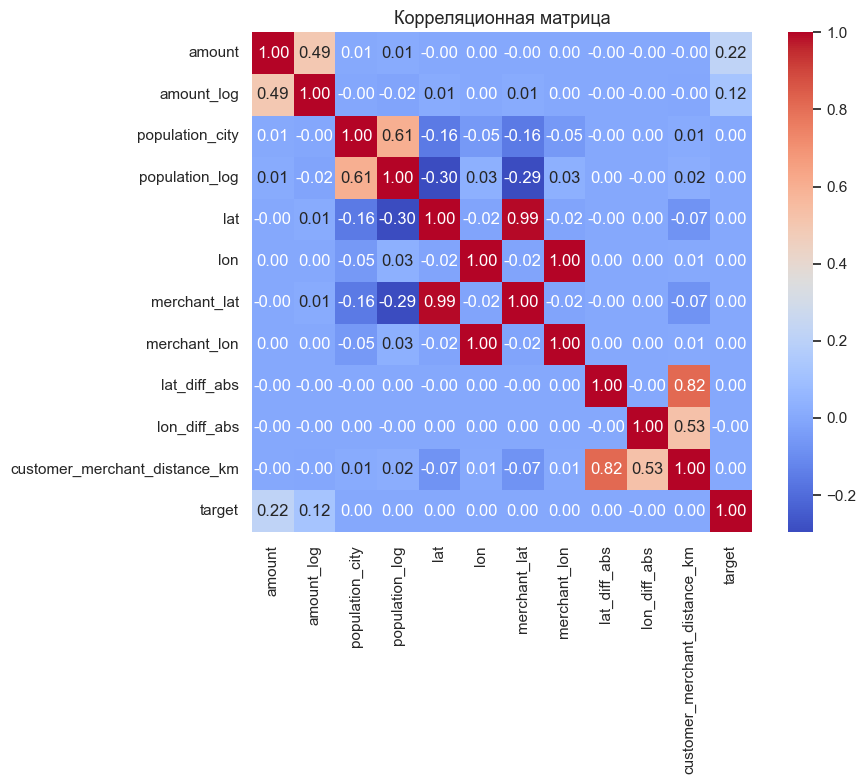

In [24]:

numeric_features = [
    "amount",
    "amount_log",
    "population_city",
    "population_log",
    "lat",
    "lon",
    "merchant_lat",
    "merchant_lon",
    "lat_diff_abs",
    "lon_diff_abs",
    "customer_merchant_distance_km",
    "target",
]
corr_matrix = df_enriched[numeric_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Корреляционная матрица")
plt.tight_layout()
plt.show()



## Инсайты для feature engineering


In [25]:

overall_fraud_rate = df_enriched['target'].mean() * 100

cat_top_risk = cat_summary.sort_values('fraud_rate', ascending=False).head(3).reset_index()
cat_top_volume = cat_summary.sort_values('transactions', ascending=False).head(3).reset_index()

state_top_risk = state_summary.sort_values('fraud_rate', ascending=False).head(3).reset_index()
merch_top_risk = merch_summary.sort_values('fraud_rate', ascending=False).head(5).reset_index()
job_top_risk = job_summary.sort_values('fraud_rate', ascending=False).head(3).reset_index()
hour_top_risk = hour_stats.sort_values('fraud_rate', ascending=False).head(3)
amount_quantiles = df_enriched.groupby('target')['amount'].quantile([0.5, 0.75, 0.95]).unstack(level=0)

insights = f"""
- **Общий уровень фрода:** {overall_fraud_rate:.3f}% (сильный дисбаланс классов, требуется корректировка метрик / сэмплирования).
- **Категории с повышенным риском:** {', '.join(f"{row['cat_id']} ({row['fraud_rate_pct']:.2f}%)" for _, row in cat_top_risk.iterrows())}. Имеет смысл создать частотные/таргетные кодировки по `cat_id` и взаимодействия с временем.
- **Категории с наибольшим объемом:** {', '.join(f"{row['cat_id']} ({row['transactions']:,} транзакций)" for _, row in cat_top_volume.iterrows())}. Для них полезны отдельные агрегаты (средний чек, количество фродов).
- **Часы суток с пиковой активностью фрода:** {', '.join(f"{int(row.transaction_hour)}h ({row.fraud_rate_pct:.2f}%)" for _, row in hour_top_risk.iterrows())}. Добавьте признаки `transaction_hour`, `is_night`, сглаженные rolling-метрики.
- **География:** штаты с наибольшим fraud rate при достаточном объеме — {', '.join(f"{row['us_state']} ({row['fraud_rate_pct']:.2f}%)" for _, row in state_top_risk.iterrows())}. Признаки `us_state`, `city`, target encoding, а также расстояние клиент-мерчант полезны.
- **Мерчанты:** топ рискованных мерчантов — {', '.join(f"{row['merch']} ({row['fraud_rate_pct']:.2f}%)" for _, row in merch_top_risk.iterrows())}. Используйте частотные, таргетные и поведенческие агрегаты по мерчанту.
- **Профессии:** {', '.join(f"{row['jobs']} ({row['fraud_rate_pct']:.2f}%)" for _, row in job_top_risk.iterrows())} — стоит создать признаки по job-группам или embeddings профессий.
- **Сумма транзакции:** медианы и хвосты различаются (Fraud 95-й перцентиль = {amount_quantiles.loc[0.95, 1]:.2f} vs Legit = {amount_quantiles.loc[0.95, 0]:.2f}). Добавьте лог-преобразование, биннинг и отклонения от пользовательских/мерчант агрегатов.
- **Временные агрегаты:** добавьте rolling-признаки числа транзакций/фродов за последние N часов/дней по пользователю, мерчанту и категории; темп изменения суммы.
- **Комбинации признаков:** взаимодействия `cat_id × hour`, `state × cat_id`, `gender × category` показывают различия в распределениях и могут усилить модель.
"""

display(Markdown(insights))



- **Общий уровень фрода:** 0.573% (сильный дисбаланс классов, требуется корректировка метрик / сэмплирования).
- **Категории с повышенным риском:** shopping_net (1.72%), misc_net (1.44%), grocery_pos (1.40%). Имеет смысл создать частотные/таргетные кодировки по `cat_id` и взаимодействия с временем.
- **Категории с наибольшим объемом:** gas_transport (79,995 транзакций), grocery_pos (74,875 транзакций), home (74,743 транзакций). Для них полезны отдельные агрегаты (средний чек, количество фродов).
- **Часы суток с пиковой активностью фрода:** 22h (2.77%), 23h (2.75%), 1h (1.59%). Добавьте признаки `transaction_hour`, `is_night`, сглаженные rolling-метрики.
- **География:** штаты с наибольшим fraud rate при достаточном объеме — AK (1.50%), NE (0.81%), TN (0.81%). Признаки `us_state`, `city`, target encoding, а также расстояние клиент-мерчант полезны.
- **Мерчанты:** топ рискованных мерчантов — fraud_Herman, Treutel and Dickens (2.68%), fraud_Fisher-Schowalter (2.45%), fraud_Gottlieb, Considine and Schultz (2.36%), fraud_Padberg-Welch (2.30%), fraud_Gleason-Macejkovic (2.16%). Используйте частотные, таргетные и поведенческие агрегаты по мерчанту.
- **Профессии:** Lawyer (6.34%), Community development worker (5.31%), TEFL teacher (5.23%) — стоит создать признаки по job-группам или embeddings профессий.
- **Сумма транзакции:** медианы и хвосты различаются (Fraud 95-й перцентиль = 1081.96 vs Legit = 189.55). Добавьте лог-преобразование, биннинг и отклонения от пользовательских/мерчант агрегатов.
- **Временные агрегаты:** добавьте rolling-признаки числа транзакций/фродов за последние N часов/дней по пользователю, мерчанту и категории; темп изменения суммы.
- **Комбинации признаков:** взаимодействия `cat_id × hour`, `state × cat_id`, `gender × category` показывают различия в распределениях и могут усилить модель.
